# AI4ALL Sessió 3.


## Classificació d'imatges

**Objectius**
Aquesta sessió introdueix l'ús pràctic de les xarxes neuronals dins el marc de la classificació multi-classe. Per a això cal dominar els conceptes relacionats amb les xarxes neuronals i els paràmetres associats.

Els objectius d'aquesta sessió són:
* Aplicar models de xarxes neurals, posant l'èmfasi en:
 1. Aplicar diferents topologies de xarxes neurals i entendre els avantatges de cada una.
 2. Avaluar correctament l'error del model
 3. Visualitzar les dades i el model resultant
* Ésser capaç d'aplicar tècniques de xarxes neurals en casos reals
* Validar els resultats en dades reals
* Fomentar la capacitat per presentar resultats tècnics d'aprenentatge computacional de forma adequada davant altres persones

**Materials**

1. Base de dades amb imatges de digits (github). Aquesta base de dades està separada en els següents conjunts:
 * Train: la xarxa neural s'haurà d'entrenar sobre aquest conjunt.
 * Validació: la xarxa entrenada en el conjunt de Train s'haurà d'evaluar sobre el conjunt de validació.
 2. [Llibreria pytorch de python.](https://pytorch.org/docs/stable/index.html)
3. Codi d'exemple.


**Base de dades**

Entrenarem la xarxa neural a la base de dades MNIST, una base de dades formada per imatges de digits escrits a mà.

![](cnn/mnist_plot-800x600.png)

Concretament, s'haurà d'aprendre una xarxa neural per a classificar cadascun dels tipus de digit a la base de dades $y \in \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\}$. Per tant, la xarxa tindrá 10 sortides i el digit predit correspondrà a la posició amb una magnitut més gran. Per exemple, el següent vector correspón al número 3. El 8 és lleugerament més provable que la resta ja que 3 i 8 comparteixen algunes semblances.

``[0.01, 0.01, 0.01, 0.9, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01]``


A continuació us proporcionem un exemple interactiu de codi i del funcionament de PyTorch. **Recordeu que cada cel·la depen de l'anterior i cal executar-les totes en ordre**.


**Exemple amb PyTorch**
0. Instal·lació de la llibreria.
  1. Triar la configuració dessitjada i seguir la comanda especificada a la [pàgina de pytorch](https://pytorch.org/).
  2. Instal·lar dependències per a executar aquest notebook (en cas que el volgueu executar interactivament).
    * `numpy`
    * `matplotlib`
  3. [Jupyter notebook](http://jupyter.org/install). 
  4. (Opcional) Nvidia Drivers i CUDA per a permetre execució en paral·lel en una GPU.
  
Recordeu ser consistents en la versió de python que utilitzeu. Recomanem utilitzar python3.6.

### 1. Entrenem una xarxa neural
1. Carreguem les llibreries i i la base de dades. En aquest cas les dades estan comprimides en un arxiu de tipus ``.npy`` però podria ser perfectament una carpeta amb imatges.

In [1]:
%matplotlib inline

import torch # Import main library
from torch.utils.data import DataLoader # Main class for threaded data loading
import matplotlib.pyplot as plt
import numpy as np

# Optimizaiton config
batch_size = 200 # Number of samples used to estimate the gradient (bigger = stable training & bigger learning rate)
learning_rate = 0.004 # Optimizer learning rate
epochs = 0 # Number of iterations over the whole dataset.

# Prepare data
train_data = np.load('cnn/data/train.npy')
val_data = np.load('cnn/data/val.npy')

train_images = np.array(train_data.item()["images"])
val_images = np.array(val_data.item()["images"])
train_labels = np.array(train_data.item()["labels"])
val_labels = np.array(val_data.item()["labels"])

train_size = train_labels.shape[0]
val_size = val_labels.shape[0]

print(train_size, "training images of size", train_images.shape[1:])

47995 training images of size (28, 28)


Verifiquem que les dades s'hagin carregat correctament (s'hauria de veure 25 dibuixos de digits):

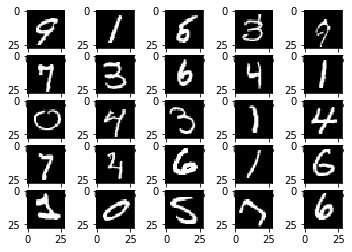

In [2]:
plt.figure()
train_indices = np.random.permutation(train_size)
for i in range(5):
    for j in range(5):
        plt.subplot(5, 5, 1 + i*5+j)
        plt.imshow(train_images[train_indices[i*5+j], :, :], cmap="gray")

2. Creem una xarxa neural amb 3 capes: input, output i una hidden layer (layer2). És important que les dimensions d'entrada i sortida siguin correctes: l'entrada ha de ser 28 * 28 (num de pixels de la imatge, que té mida 28 x 28), i la sortida ha de ser de mida 10, ja que hi ha 10 tipus de digits.

In [3]:
class NeuralNet(torch.nn.Module):
    def __init__(self, n_neurones=8, n_sortides=10):
        super().__init__() # Necessary for torch to detect this class as trainable
        # Here define network architecture
        self.layer1 = torch.nn.Linear(28**2, n_neurones) # Linear layer with n_neurones
        self.layer2 = torch.nn.Linear(n_neurones, n_neurones * 2) # Linear layer with n_neurones neurones * 2
        self.output = torch.nn.Linear(n_neurones * 2, 10) # Linear layer with 1 neuron (binary output)
        
    def forward(self, x):
        # Here define architecture behavior
        x = torch.sigmoid(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        return torch.sigmoid(self.output(x)) # Binary output
    
# Instantiate network
model = NeuralNet()        

3. Creem l'optimitzador, declarem la funció a optimitzar, i la resta de funcions auxiliars per a optimitzar el model.

In [4]:
# Create optimizer for the network parameters
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

# Instantiate loss function
criterion = torch.nn.CrossEntropyLoss() # Binary logistic regression

# Function to iterate the training set and update network weights with batches of images.
def train(model, optimizer, criterion, dimensions_entrada=[-1, 28**2]):
    
    model.train() # training mode
    
    running_loss = 0
    running_corrects = 0
    total = 0
    
    # Loop through the the training set in steps of batch size
    for idx in range(0, train_size, batch_size):       
        optimizer.zero_grad() # make the gradients 0 
        # Prepare images (x) and labels (y) to pytorch format
        x = torch.from_numpy(train_images[train_indices[idx:(idx + batch_size)], ...]).float()
        y = torch.from_numpy(train_labels[train_indices[idx:(idx + batch_size)], ...]).long()
        output = model(x.view(*dimensions_entrada)) # forward pass
        preds = torch.max(output, 1)[1]
        loss = criterion(output, y) # calculate the loss value
        
        loss.backward() # compute the gradients
        optimizer.step() # uptade network parameters 
                
        # gather training statistics 
        running_loss += loss.item() * x.size(0)
        running_corrects += torch.sum(preds==y).item() # .item() converts type from torch to python float or int
        total += float(y.size(0))
        
    epoch_loss = running_loss / total # mean epoch loss 
    epoch_acc = running_corrects / total # mean epoch accuracy
    
    return epoch_loss, epoch_acc

# Function to iterate the validation set and update network weights with batches of images.
def val(model, criterion, dimensions_entrada=[-1, 28**2]):
    
    model.eval() # validation mode
    
    running_loss = 0
    running_corrects = 0
    total = 0
  
    # Loop through the the validation set in steps of batch size
    with torch.no_grad(): # We are not backpropagating trhough the validation set, so we can save speed
        for idx in range(0, val_size, batch_size):       
            x = torch.from_numpy(val_images[idx:(idx + batch_size), ...]).float()
            y = torch.from_numpy(val_labels[idx:(idx + batch_size), ...]).long()
            output = model(x.view(*dimensions_entrada)) # forward pass
            preds = torch.max(output, 1)[1]

            loss = criterion(output, y) # calculate the loss value

            # statistics 
            running_loss += loss.item() * x.size(0)
            running_corrects += torch.sum(preds==y).item() # .item() converts type from torch to python float or int
            total += float(y.size(0))
        
    epoch_loss = running_loss / total # mean epoch loss 
    epoch_acc = running_corrects / total # mean epoch accuracy
    
    return epoch_loss, epoch_acc



4. Iterem sobre el dataset sencer $epochs$ vegades i mostrem el train loss i accuracy. Recordeu de donar un valor a la variable ``epochs``.

In [5]:
# Main training loop
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# Remove this line out of jupyter notebooks
from IPython import display 
for epoch in range(epochs):
    t_loss, t_acc = train(model, optimizer, criterion)
    v_loss, v_acc = val(model, criterion)
    
    train_loss.append(t_loss)
    train_accuracy.append(t_acc)
    val_loss.append(v_loss)
    val_accuracy.append(v_acc)

    plt.subplot(1,2,1)
    plt.title("loss")
    plt.plot(train_loss, 'b-')
    plt.plot(val_loss, 'r-')
    plt.legend(["train", "val"])
    plt.subplot(1,2,2)
    plt.title("accuracy")
    plt.plot(train_accuracy, 'b-')
    plt.plot(val_accuracy, 'r-')
    plt.legend(["train", "val"])
    display.clear_output(wait=True)
    display.display(plt.gcf())
display.clear_output(wait=True)

Hauria d'acabar a ~80% train accuracy i val accuracy (percentatge d'imatges classificats correctement). 



### 2. Xarxes neurals Convolucionals
Com s'ha vist a la part teòrica, hi ha un tipus de xarxa neural més adequat per a imatges. Aquestes son les xarxes neurals convolucionals. La única diferència respecte una xarxa neural tradicional és que la xarxa convolucional utilitza un nou tipus de capa de neurones, la capa convolucional. Aquesta capa no es connecta a tota la imatge d'entrada sinó només a una regió, i les connexions es reutilitzen de regió en regió fins que s'ha passat per tota la imatge.

<img src="cnn/convlayer.png" style="width:50%;"/>

a pytorch podem definir una xarxa convolucional de la següent manera ([veure documentació](https://pytorch.org/docs/stable/search.html?q=conv2d&check_keywords=yes&area=default)):

In [6]:
canals_entrada = 1 # les imatges son en blanc i negre, per tant, no cal tres canals de color
canals_sortida = 16 # Apliquem 16 neurones que es desplacen per la imatge
mida_finestra = 5 # mida de la finestra que apliquem
conv_layer = torch.nn.Conv2d(canals_entrada, canals_sortida, mida_finestra)

Penseu com si cada canal de sortida (cada neurona) detectés patrons diferents dins de la imatge. Si afegim una nova capa convolucional a sobre d'aquesta, cada punt dels $5\times 5$ punts de la finestra detectarà combinacions dels 16 patrons detectats per la capa anterior. D'aquesta manera anem construint una representació incrementalment abstracta del contingut de la imatge (1. línies, 2. corves, 3. idea general del número (número de panxes, per exemple), 4. el número).

Podem provar d'aplicar la capa sobre un dels números de la base de dades per a veure què passa:

In [7]:
imatge = torch.from_numpy(train_images[0]) # passem imatge a format pytorch
imatge = imatge.view(1,1,28,28) # pytorch espera dimensions = mida_batch, canals, alçada, amplada
imatge = imatge.float() # convertim a nombre real
out = conv_layer(imatge)
print(out.size())

torch.Size([1, 16, 24, 24])


Podem veure que la sortida té 16 canals, i s'ha empetitit, de 28 a 24 pixels. Això es deu a que la finestra és de $5\times5$, i per tant, el punt central està a la posició 3 de la finestra. D'aquesta manera, el punt central comença a la posició 3 de la imatge, i acaba al final - 3, deixant-se els dos primers pixels i els dos últims. Per això baixa de 28 a 24 pixels.

Quin aspecte té la sortida?

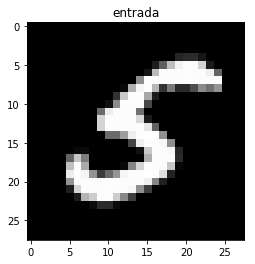

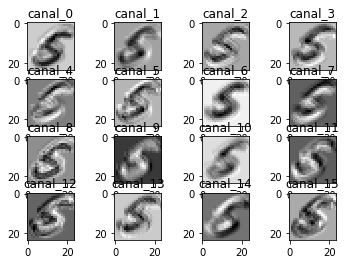

In [8]:
def mostra_imatge(im):
    out = im.data.numpy()
    out = out - out.min()
    out = out / out.max()
    out = out * 255
    out = out.repeat(3, 2)
    out = out.astype('uint8')
    plt.imshow(out)
    
plt.figure()
plt.title("entrada")
mostra_imatge(imatge.view(28,28,1))
plt.figure()
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,1 + i * 4 + j)
        plt.title("canal_%d" %(i*4+j))
        canal = out[0,i*4+j,:,:].view(24, 24, 1)
        mostra_imatge(canal)

Recordeu que aquesta convolució no ah estat entrenada, i, per tant, és inicialitzada aleatoriament. Tot i això es pot comprovar com algun canal s'especialitza en detectar cantonades interiors, exteriors, o corves (en color blanc més intens).

Ara ja podem entrenar una xarxa convolucional. Com a exercici, podeu provar de modificar la xarxa anterior sense mirar el següent codi:

In [9]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, n_neurones, n_sortides, mida_finestra):
        super().__init__()
        self.layer1 = nn.Conv2d(1, n_neurones, mida_finestra)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.nolinear1 = nn.ReLU()
        self.layer2 = nn.Conv2d(n_neurones, n_neurones * 2, mida_finestra)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.nolinear2 = nn.ReLU()
        self.layer3 = nn.Linear(4*4*n_neurones*2, n_sortides)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.nolinear1(x)
        x = self.pool1(x)
        x = self.layer2(x)
        x = self.nolinear2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        return self.layer3(x)

    
epochs = 0 # numero d'iteracions d'entrenament
learning_rate = 0.001 # coefficient d'aprenentatge

model = CNN(16, 10, 5)
optimizer = torch.optim.Adam(model.parameters(), learning_rate)


Com podeu veure hem afegit una nova capa: Pool2d. El que fa aquesta capa és moure una finestra lliscant sobre la sortida d'una de les capes de la xarxa i retorna el màxim de la finestra en cada punt. Això té dos efectes:
1. Si tenim una finestra de mida 2, com per cada 2 activacions en retornem una (el màxim), la mida de la sortida queda dividida entre 2.
2. Com que dels dos només retornem el màxim, no importa si aquest es troba a la dreta o a l'esquerra de la finestra. Això vol dir que si movem la imatge un pixel a la dreta o a l'esquerra, la sortida de la xarxa no canviarà. Per tant, la xarxa és molt més robusta a petits desplaçaments.

**ATENCIÓ: Si va molt lent, passar a següent apartat**

Podem reutilitzar codi per a entrenar aquest model:

In [10]:
# Main training loop
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

# Remove this line out of jupyter notebooks
from IPython import display 
for epoch in range(epochs):
    t_loss, t_acc = train(model, optimizer, criterion, [-1, 1, 28, 28])
    v_loss, v_acc = val(model, criterion, [-1, 1, 28, 28])
    
    train_loss.append(t_loss)
    train_accuracy.append(t_acc)
    val_loss.append(v_loss)
    val_accuracy.append(v_acc)
      
    plt.subplot(1,2,1)
    plt.title("loss")
    plt.plot(train_loss, 'b-')
    plt.plot(val_loss, 'r-')
    plt.legend(["train", "val"])
    plt.subplot(1,2,2)
    plt.title("accuracy")
    plt.plot(train_accuracy, 'b-')
    plt.plot(val_accuracy, 'r-')
    plt.legend(["train", "val"])
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
#torch.save({"net": model.state_dict()}, "cnn/model_cnn_gran.pth") # guardem pesos
display.clear_output(wait=True)

### Models pre-entrenats
He entrenat una xarxa neural convolucional utiltzant GPU. Podeu utilitzar les seves connexions per a inicialitzar la xarxa de l'apartat anterior.

In [11]:
import torch
pesos = torch.load("cnn/model_cnn.pth")
model.load_state_dict(pesos["net"])

# Mirem quin percentatge d'encert te el model amb pesos carregats sobre el conjunt de validació
v_loss, v_acc = val(model, criterion, [-1, 1, 28, 28])
print("%.02f%% d'encert" %(100*v_acc))

from scipy.misc import imresize

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:116: UserWarning: 
    Found GPU1 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


97.30% d'encert


### Exercicis
1. Classifiqueu un digit escrit per vosaltres:
   
   1.1. Utilitzeu mspaint, gimp, o google drive, per a dibuixar un digit a mà amb pinzell blanc sobre fons negre.
   
   1.2. Carregueu-lo a una variable de python (podeu utilitzar `from scipy.misc import imread` per a tenir la funció `imatge = imread("ruta/imatge.jpg")`).
   
   1.3. Si no l'hem guardat amb mida 28x28, utilitzem la funció imresize (`from scipy.misc import imresize`). `imatge = imresize(imatge, (28, 28))`
  
   1.4. Utilitzeu la funció torch.from_numpy(imatge_carregada) per a convertir-la a format torch.
  
   1.5. Fem la mitja dels canals de color per a que tingui un sol canal en blanc i negre: `imatge = imatge.mean(2)`.
   
   1.6. Canviem el format de les dimensions a un format que la xarxa sàpiga interpretar: `imatge = imatge.view(1,1,28,28).float()`
  
   1.7. Passem la imatge a la xarxa i observem la sortida. La funció `max` de pytorch retorna dos valors, el màxim i la posició on es troba.
  
  
2. He entrenat una xarxa més potent que es troba a `cnn/model_cnn_gran.pth`. 

   2.1. Haureu de modificar la classe `CNN` per a que tingui la següent forma:
       layer1
       nolinear1
       pooling1
       layer2
       nolinear2
       layer3
       nolinear3
       pooling2
       layer4
    Cada `layer` duplica la mida de la seva entrada, per tant, layer3: n_neurones -> n_neurones * 4. Heu d'ajustar l'entrada de `layer4` per a que expressi la mida nova després de la sortida de pooling2. Recordeu que cada capa de convolució resta 4 a la mida de la imatge, i cada capa de pooling divideix entre 2.    
  
   2.2. Quin percentatge d'encert dóna?
   